In [14]:
%matplotlib inline


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, sys, pathlib
import xbout
import scipy
import xhermes

onedrive_path = onedrive_path = str(os.getcwd()).split("OneDrive")[0] + "OneDrive"
sys.path.append(os.path.join(onedrive_path, r"Project\python-packages\sdtools"))
sys.path.append(os.path.join(onedrive_path, r"Project\python-packages\soledge"))
sys.path.append(os.path.join(onedrive_path, r"Project\python-packages"))

from hermes3.utils import *

# import gridtools.solps_python_scripts.setup
# from gridtools.solps_python_scripts.utilities.last10s       import read_last10s

from hermes3.fluxes import *
from hermes3.case_db import *
from hermes3.load import *
from hermes3.named_selections import *
from hermes3.plotting import *
from hermes3.grid_fields import *
from hermes3.accessors import *

from code_comparison.code_comparison import *
from code_comparison.solps_pp import *
from code_comparison.viewer_2d import *

import general.plotstyle

from xhermes.load import open_hermesdataset
from xhermes.accessors import *

%load_ext autoreload
%autoreload 2

plt.close("all")
%matplotlib inline

print("Done")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Done


In [31]:

cs = dict()   # casestore

ds = open_hermesdataset(
    datapath = r"C:\Users\Mike\OneDrive\Project\lot2_2d\From\Lloyd\Neutral_temperature_density_oscillation_case\BOUT.dmp.0.nc"
    )

ds = ds.hermes.extract_1d_tokamak_geometry()
ds["M"] = ds["Vd+"] / np.sqrt(constants("q_e")*(ds["Td+"] + ds["Te"])/(constants("mass_p")*2))

In [17]:
ds = cs["base"]

In [20]:
len(ds["t"])

268

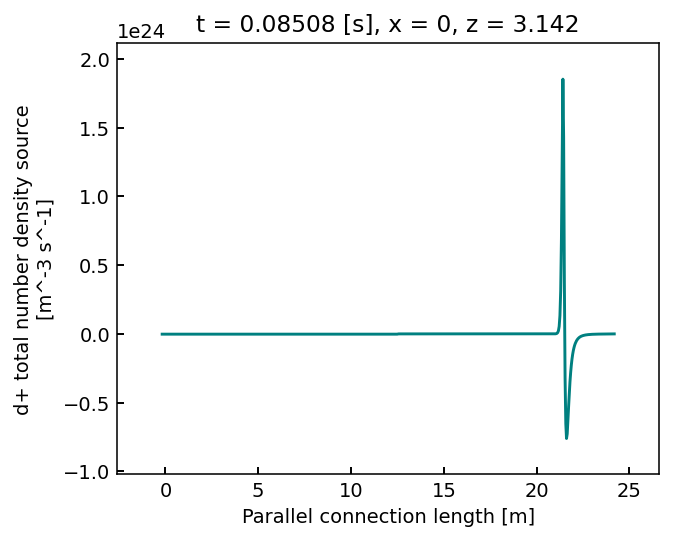

In [39]:
last = ds.isel(t=-1)

last["SNd+"].plot()

In [40]:
ds.data_vars

Data variables:
    Bxy                            (pos) float64 3kB dask.array<chunksize=(400,), meta=np.ndarray>
    Ed+_iz                         (t, pos) float64 858kB dask.array<chunksize=(1, 400), meta=np.ndarray>
    Ed+_rec                        (t, pos) float64 858kB dask.array<chunksize=(1, 400), meta=np.ndarray>
    Ed_target_recycle              (t, pos) float64 858kB dask.array<chunksize=(1, 400), meta=np.ndarray>
    Edd+_cx                        (t, pos) float64 858kB dask.array<chunksize=(1, 400), meta=np.ndarray>
    Fd+_iz                         (t, pos) float64 858kB dask.array<chunksize=(1, 400), meta=np.ndarray>
    Fd+_rec                        (t, pos) float64 858kB dask.array<chunksize=(1, 400), meta=np.ndarray>
    Fdd+_cx                        (t, pos) float64 858kB dask.array<chunksize=(1, 400), meta=np.ndarray>
    G1                             (pos) float64 3kB dask.array<chunksize=(400,), meta=np.ndarray>
    G2                             (pos) flo

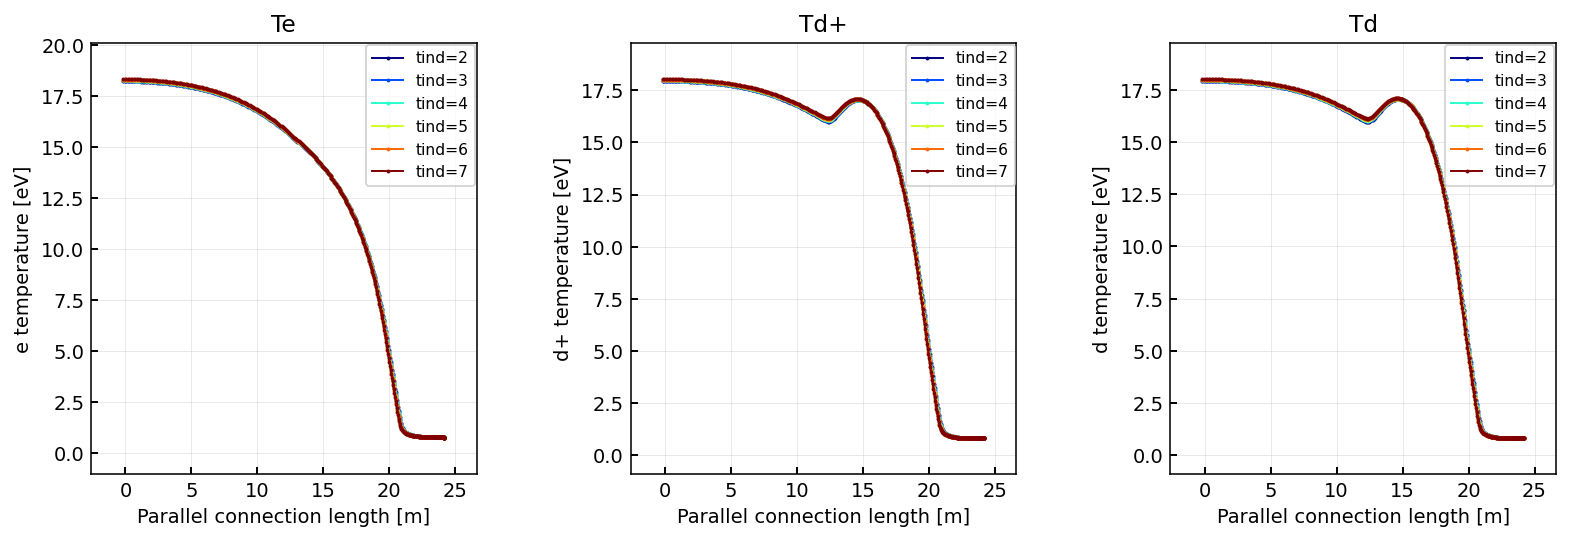

In [33]:
plt.close("all")
time_idx = [2, 3, 4, 5, 6, 7]
colors = make_cmap("jet", len(time_idx))

def plot(list_params):
    fig, axes = plt.subplots(1, len(list_params), figsize=(len(list_params)*4.5, 4), dpi = 140)
    fig.subplots_adjust(wspace = 0.4)
    
    
    times = np.linspace(5, len(ds.coords["t"])-1, 10, dtype=int)

    alphas = [1] * len(times)
    for j, param in enumerate(list_params):
        for i, tind in enumerate(time_idx):
            data = ds[param].isel(t=tind)
            # data = data.sel(pos=slice(67.6,68.5))
            data.plot(ax = axes[j], x = "pos", marker = "o", label = f"tind={tind}", color = colors[i], ms = 1, lw = 1, alpha = alphas[i])
            
        axes[j].grid()
        axes[j].set_title(param)
        axes[j].legend(fontsize=8)
        # axes[j].set_yscale("symlog")
        
# plot(["Pe", "Pd+", "Pd"])
plot(["Te", "Td+", "Td"])
# plot(["Ne", "Nd"])
# plot(["M", "NVd+", "NVd"])

# plot(["Sd+_iz", "Sd+_rec", "Fdd+_cx"])
# plot(["Rd+_ex", "Rd+_rec"])

# Plot ddt against the slowdown
- No trace in anything apart from ion momentum and ion density 
- The momentum spike corresponds to the front skipping from one cell to another
- However the slowdown happens before this in a "pre-spike" of momentum
- We must find out what this corresponds to.

In [152]:
((65-31)*5)/0.1

1700.0

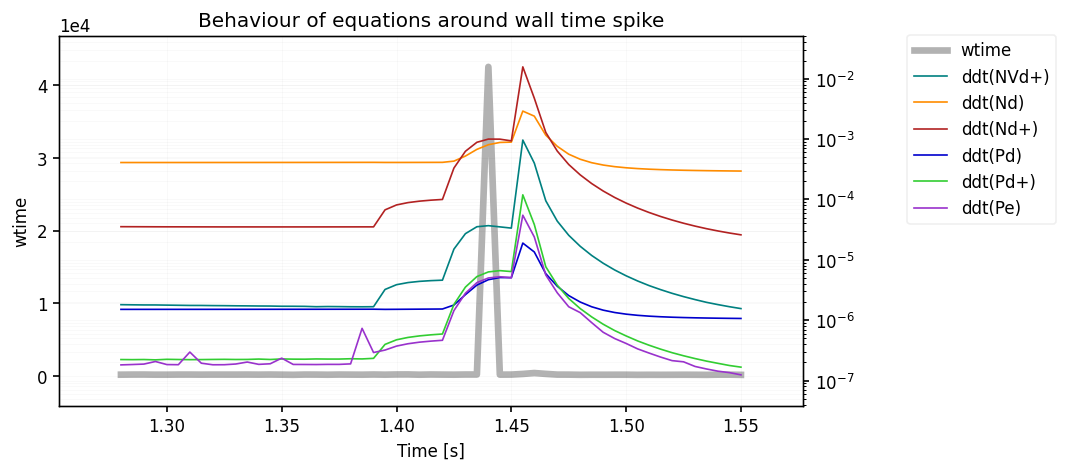

In [120]:
ds = cs["base"].ds.isel(t=slice(10,65), pos = slice(2,-2))

list_params = []
for var in ds.data_vars:
    if "ddt" in var and not any([x in var for x in []]):
        list_params.append(var)
list_params.sort()

fig, ax = plt.subplots(figsize = (8,4), dpi = 120)
ds["wtime"].plot(ax = ax,  c = "k", label = "wtime", lw = 4, alpha = 0.3)

ax2 = ax.twinx()

res = {}
for param in list_params:
    res[param] = ds[param]
    res[param] = np.sqrt(np.mean(res[param]**2, axis = 1))    # Root mean square
    ax2.plot(ds.coords["t"], res[param], label = param, lw = 1)

ax2.set_yscale("log")
ax.set_title("Behaviour of equations around wall time spike")
fig.legend(bbox_to_anchor=(1,0.9), loc = "upper left")
# ds["ddt(NVd+)"].plot(ax = ax)

## Domain integrals

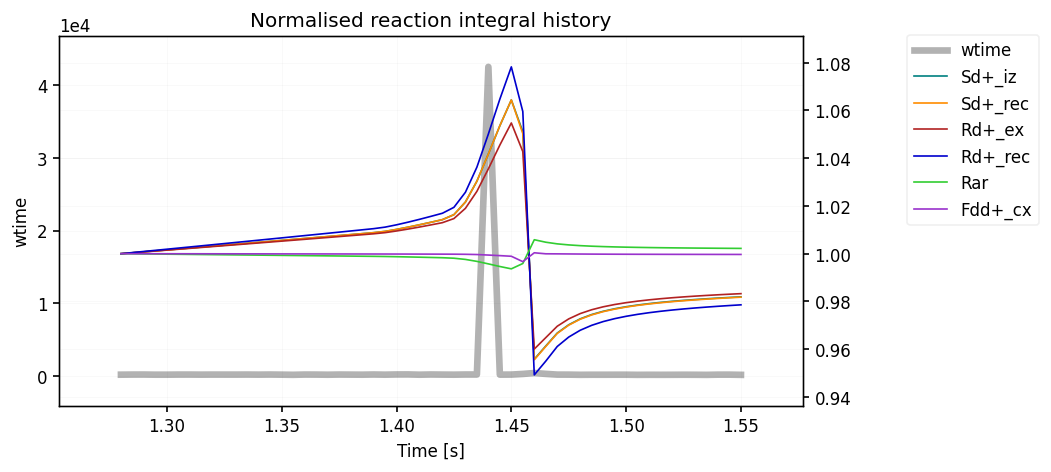

In [149]:
ds = cs["base"].ds.isel(t=slice(10,65), pos = slice(2,-2))

list_params = ["Sd+_iz", "Sd+_rec", "Rd+_ex", "Rd+_rec", "Rar", "Fdd+_cx"]


fig, ax = plt.subplots(figsize = (8,4), dpi = 120)
ds["wtime"].plot(ax = ax,  c = "k", label = "wtime", lw = 4, alpha = 0.3)

ax2 = ax.twinx()

res = {}
for param in list_params:
    data = (ds[param]*ds["dv"]).sum("pos")
    data /= data[0]
    ax2.plot(ds.coords["t"], data, label = param, lw = 1)

# ax2.set_yscale("log")
ax.set_title("Normalised reaction integral history")
fig.legend(bbox_to_anchor=(1,0.9), loc = "upper left")
# ds["ddt(NVd+)"].plot(ax = ax)

## CVODE settings

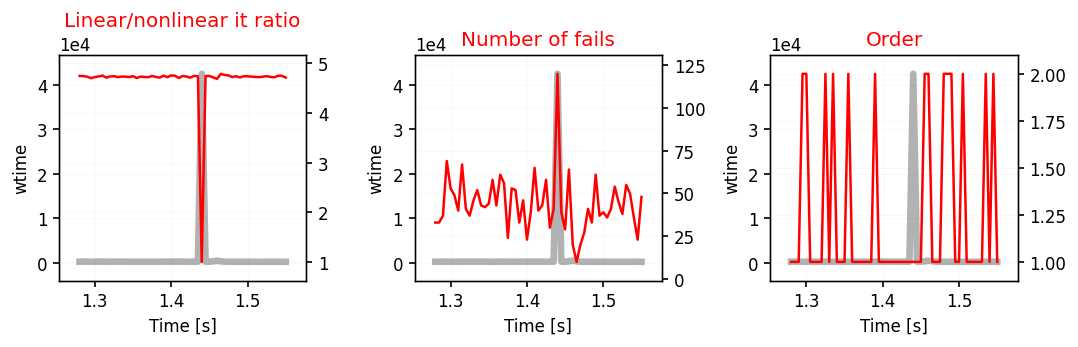

In [143]:
wtime = ds["wtime"]
t = ds["t"] * 1000
nliters = ds["cvode_nliters"]
nfails = ds["cvode_num_fails"]
lorder = ds["cvode_last_order"]
nniters = ds["cvode_nniters"]

stime = np.diff(t, prepend = t[0]*0.99)
wtime_per_stime = wtime/stime
lratio = np.diff(nliters, prepend=nliters[1]*0.99) / np.diff(nniters, prepend=nniters[1]*0.99)   # Ratio of linear to nolinear iterations
fails = np.diff(nfails, prepend = nfails[1]*0.99)
fails[0] = fails[1]
lorder[0] = lorder[1]
wtime_per_stime[0] = wtime_per_stime[1]

ds = cs["base"].ds.isel(t=slice(10,65), pos = slice(2,-2))


fig, axes = plt.subplots(1,3, figsize = (9,3), dpi = 120)
ax = axes[0]
ds["wtime"].plot(ax = ax,  c = "k", label = "wtime", lw = 4, alpha = 0.3)
ax2 = ax.twinx()
ax2.plot(ds["t"], lratio, c = "r")
ax.set_title("Linear/nonlinear it ratio", color = "r")

ax = axes[1]
ds["wtime"].plot(ax = ax,  c = "k", label = "wtime", lw = 4, alpha = 0.3)
ax2 = ax.twinx()
ax2.plot(ds["t"], fails, c = "r")
# lratio.plot(ax = ax, c="r",)
ax.set_title("Number of fails", color = "r")

ax = axes[2]
ds["wtime"].plot(ax = ax,  c = "k", label = "wtime", lw = 4, alpha = 0.3)
ax2 = ax.twinx()
ax2.plot(ds["t"], lorder, c = "r")
# lratio.plot(ax = ax, c="r",)
ax.set_title("Order", color = "r")

res = {}

# ax2.set_yscale("log")

# fig.legend(bbox_to_anchor=(1,0.9), loc = "upper left")
# ds["ddt(NVd+)"].plot(ax = ax)

fig.tight_layout()

# Investigate event chain

## Pick times

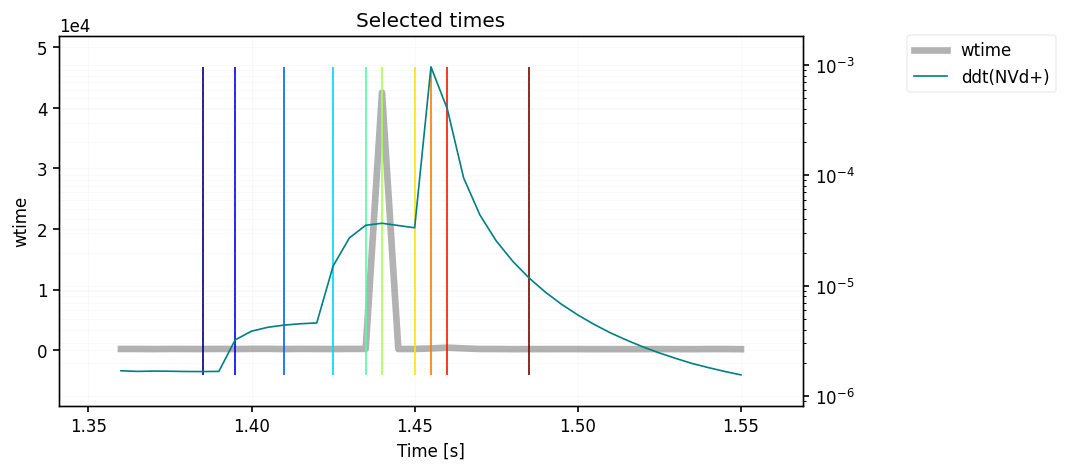

In [113]:
ds = cs["base"].ds.isel(t=slice(26,65), pos = slice(2,-2))

list_params = []
for var in ds.data_vars:
    if "ddt" in var and not any([x in var for x in []]):
        list_params.append(var)
list_params.sort()

fig, ax = plt.subplots(figsize = (8,4), dpi = 120)
ds["wtime"].plot(ax = ax,  c = "k", label = "wtime", lw = 4, alpha = 0.3)

ax2 = ax.twinx()

res = {}
for param in ["ddt(NVd+)"]:
    res[param] = ds[param]
    res[param] = np.sqrt(np.mean(res[param]**2, axis = 1))    # Root mean square
    ax2.plot(ds.coords["t"], res[param], label = param, lw = 1)

time_idx = np.array([ 5,  7, 10, 13, 15, 16, 18, 19, 20, 25])
times = ds["t"].isel(t = time_idx)
colors = make_cmap("jet", len(times))
ax.vlines(times, ax.get_ylim()[0], ax.get_ylim()[1], colors = colors, lw = 1)

ax2.set_yscale("log")
ax.set_title("Selected times")
fig.legend(bbox_to_anchor=(1,0.9), loc = "upper left")
# ds["ddt(NVd+)"].plot(ax = ax)

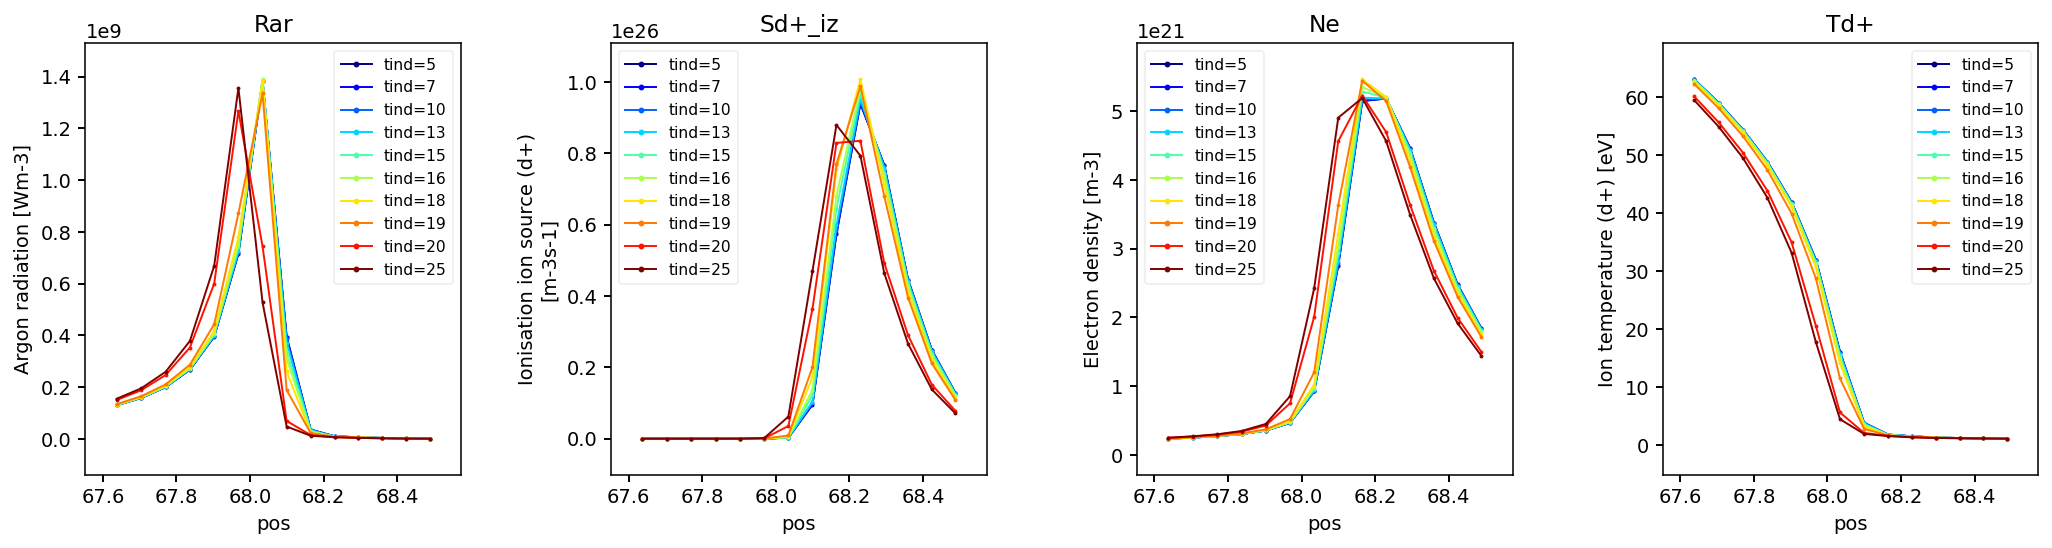

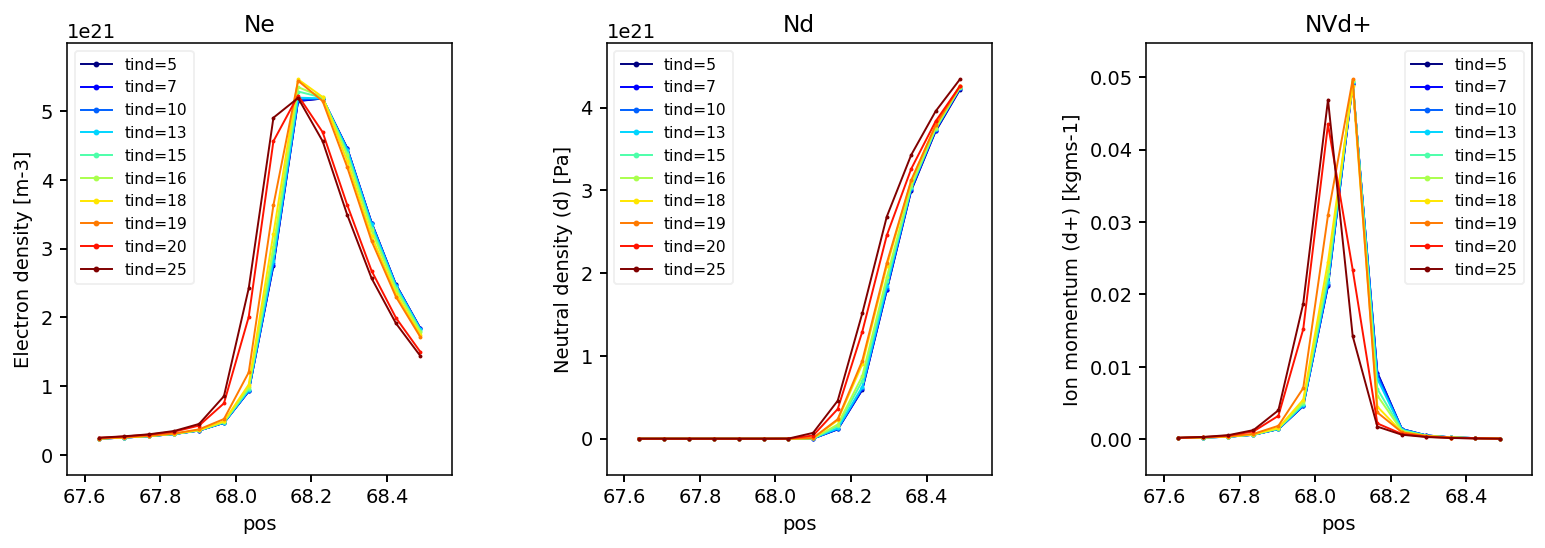

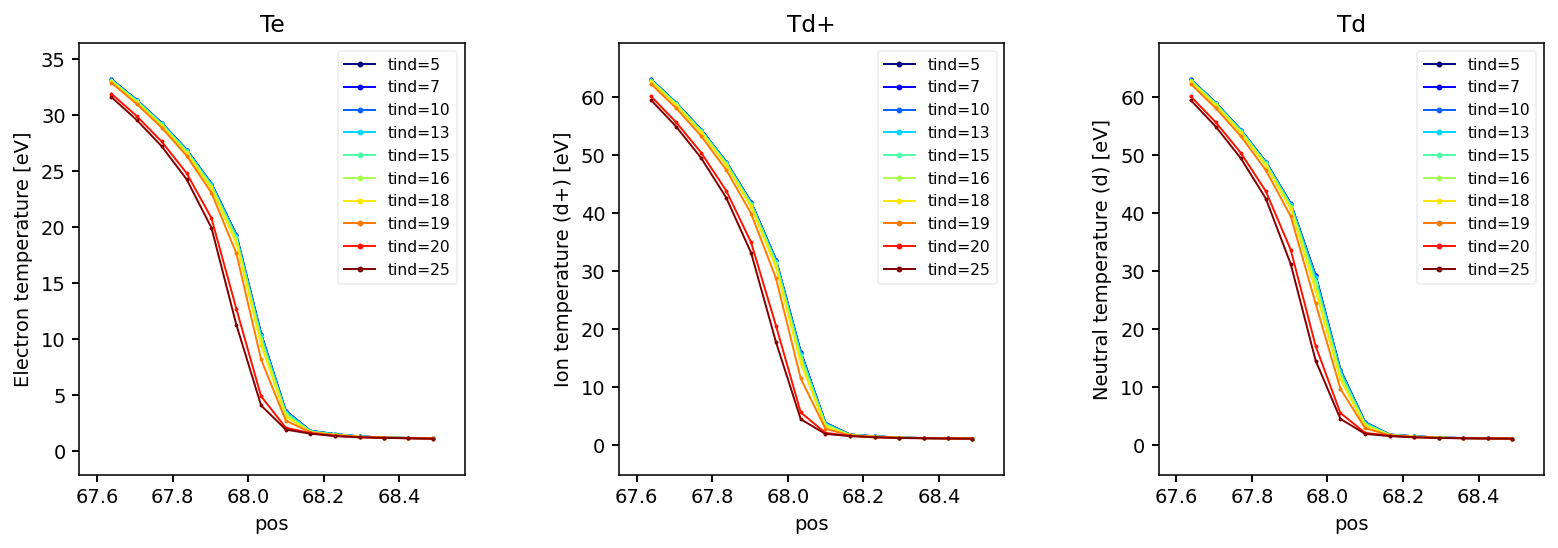

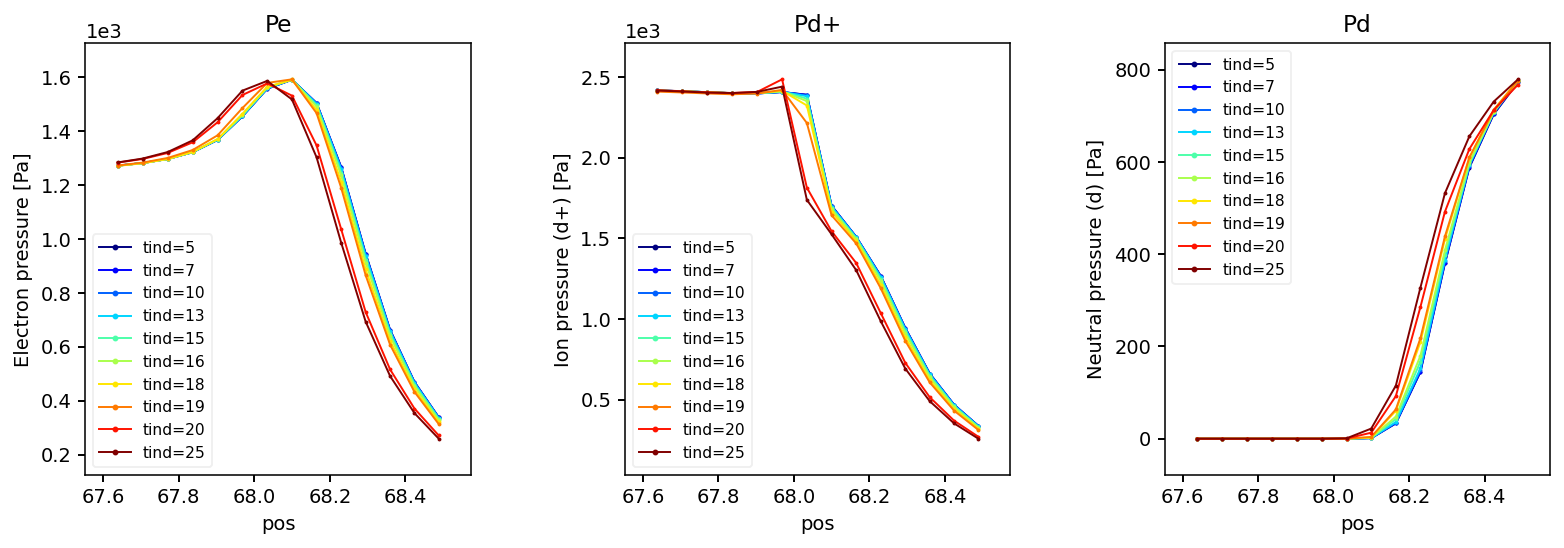

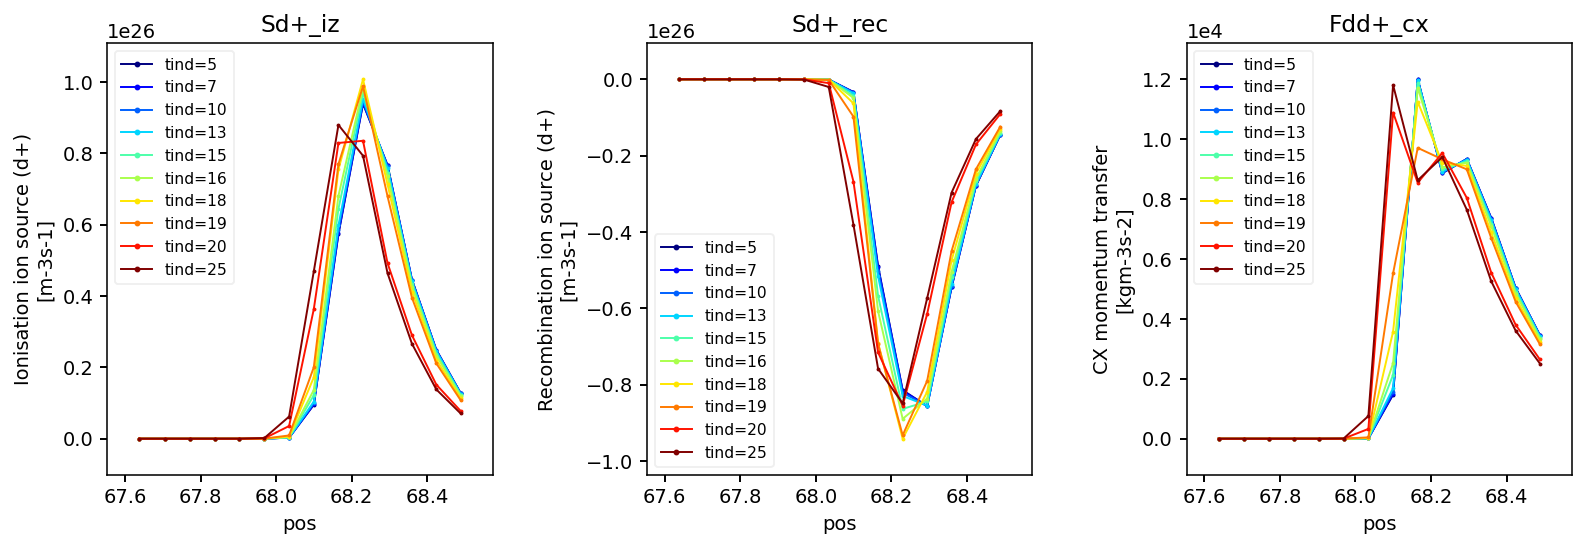

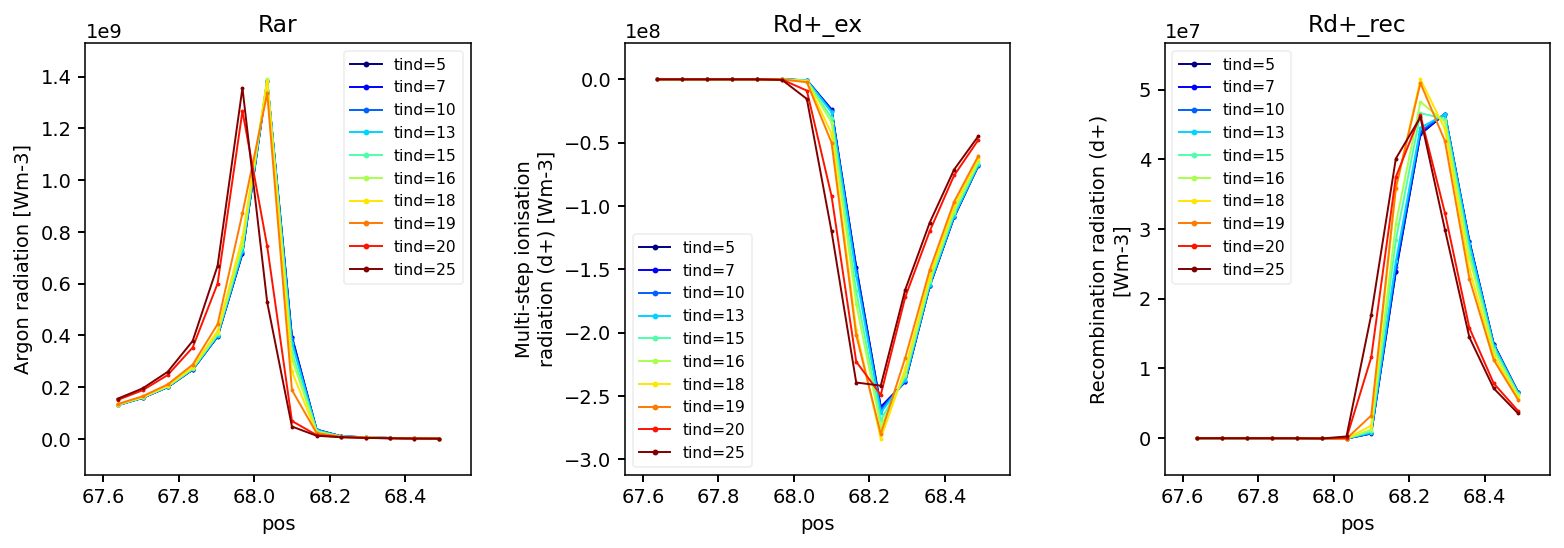

In [116]:
plt.close("all")


def plot(list_params):
    fig, axes = plt.subplots(1, len(list_params), figsize=(len(list_params)*4.5, 4), dpi = 140)
    fig.subplots_adjust(wspace = 0.4)
    
    
    times = np.linspace(5, len(ds.coords["t"])-1, 10, dtype=int)

    alphas = [1] * len(times)
    for j, param in enumerate(list_params):
        for i, tind in enumerate(time_idx):
            data = ds[param].isel(t=tind)
            data = data.sel(pos=slice(67.6,68.5))
            data.plot(ax = axes[j], x = "pos", marker = "o", label = f"tind={tind}", color = colors[i], ms = 1, lw = 1, alpha = alphas[i])
            
        axes[j].grid()
        axes[j].set_title(param)
        axes[j].legend(fontsize=8)
        # axes[j].set_yscale("symlog")
        
plot(["Rar", "Sd+_iz", "Ne", "Td+"])
plot(["Ne", "Nd", "NVd+"])
plot(["Te", "Td+", "Td"])
plot(["Pe", "Pd+", "Pd"])
plot(["Sd+_iz", "Sd+_rec", "Fdd+_cx"])
plot(["Rar", "Rd+_ex", "Rd+_rec"])

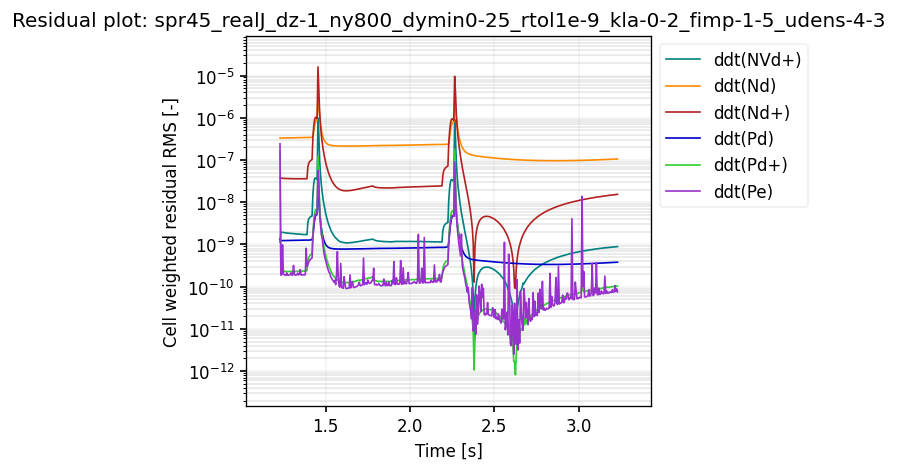

In [26]:
plot_ddt(cs["base"])